# Chap 10. Conditional Diffusion 0.1

----

Conda env : [cv_playgrounds](../../README.md#setup-a-conda-environment)

----

In [18]:
# step 1
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import numpy as np
import random


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

to_pil = transforms.ToPILImage()
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    x = x.cpu()
    return to_pil(x)

def show_images(images : [] , title_msg : str = None , labels : np.array = None):
    def last_argmin(arr):
        arr_rev = arr[::-1]
        return len(arr_rev) - 1 - np.argmin(arr_rev)

    img_num = len(images)

    col_set = [2, 3, 5]
    x = [img_num % i for i in col_set]
    cols = col_set[last_argmin(x)]
    rows = math.ceil(img_num / cols)

    fig = plt.figure(figsize=(cols, rows))
    for i in range(img_num):
        ax = fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        if labels is not None:
            ax.set_xlabel(labels[i])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    if title_msg is not None:
        plt.suptitle(title_msg)
    plt.tight_layout()
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

In [19]:
# step 2
# @title UNetCond

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


In [20]:
# step 3
# @title Diffuser

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels, gamma):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
            eps_uncond = model(x, t)
            eps = eps_uncond + gamma * (eps - eps_uncond)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)
        else:
            labels = labels.to(self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)

        images = [reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

In [21]:
# step 4

def train(dataset, batch_size, label_list,
          diffuser, num_timesteps,
          model, img_ch, img_size, device,
          epochs, lr):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        cnt = 0

        # generate samples every epoch ===================
        # images, labels = diffuser.sample(model)
        # show_images(images, labels)
        # ================================================

        for images, labels in tqdm(dataloader):
            optimizer.zero_grad()
            x = images.to(device)
            l = labels.to(device)
            t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

            if np.random.random() < 0.1:
                l = None

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t, l)
            loss = F.mse_loss(noise, noise_pred)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            cnt += 1

        if epoch % 10 == 0:
            labels = torch.tensor(np.random.choice(label_list, 9), device = device)
            test_images, labels = diffuser.sample(model, x_shape = (9, img_ch, img_size, img_size), labels = labels)
            l_lst = labels.cpu().numpy()
            show_images(test_images, title_msg = f"Epoch {epoch}", labels = l_lst)

        loss_avg = loss_sum / cnt
        losses.append(loss_avg)
        print(f'Epoch {epoch} | Loss: {loss_avg}')

    # plot losses
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # generate samples
    labels = torch.tensor(np.random.choice(label_list, 9), device = device)
    images ,labels = diffuser.sample(model, x_shape = (9, img_ch, img_size, img_size), labels = labels)
    l_lst = labels.cpu().numpy()
    show_images(images, title_msg = "Test Images", labels = l_lst)


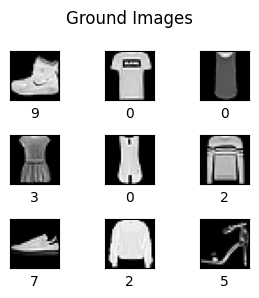

Size of dataset: 10
Label Set : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


100%|██████████| 1000/1000 [00:19<00:00, 51.40it/s]


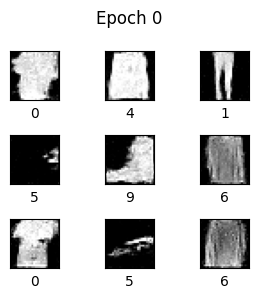

Epoch 0 | Loss: 0.05915835851640589


100%|██████████| 469/469 [00:52<00:00,  9.01it/s]


Epoch 1 | Loss: 0.03639063979786977


100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Epoch 2 | Loss: 0.03255014333214714


100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


Epoch 3 | Loss: 0.03040047831086716


100%|██████████| 469/469 [01:02<00:00,  7.48it/s]


Epoch 4 | Loss: 0.029162577700926298


100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Epoch 5 | Loss: 0.028273776149762463


100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Epoch 6 | Loss: 0.027734686384227738


100%|██████████| 469/469 [01:00<00:00,  7.74it/s]


Epoch 7 | Loss: 0.026817970553726783


100%|██████████| 469/469 [00:59<00:00,  7.87it/s]


Epoch 8 | Loss: 0.026535755057118214


100%|██████████| 469/469 [00:58<00:00,  8.00it/s]


Epoch 9 | Loss: 0.02619207232618637


100%|██████████| 1000/1000 [00:19<00:00, 51.07it/s]


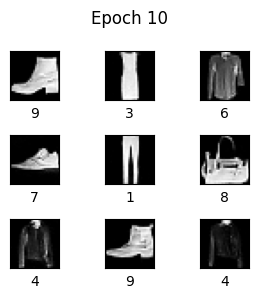

Epoch 10 | Loss: 0.025999364468938253


100%|██████████| 469/469 [00:52<00:00,  9.00it/s]


Epoch 11 | Loss: 0.025302370267509144


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 12 | Loss: 0.02495184273067822


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 13 | Loss: 0.024582042938658295


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 14 | Loss: 0.024688776217099192


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 15 | Loss: 0.024282688382210763


100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


Epoch 16 | Loss: 0.024131620570874292


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


Epoch 17 | Loss: 0.024210612132732293


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


Epoch 18 | Loss: 0.024325509646982907


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 19 | Loss: 0.02380077299604347


100%|██████████| 1000/1000 [00:19<00:00, 52.42it/s]


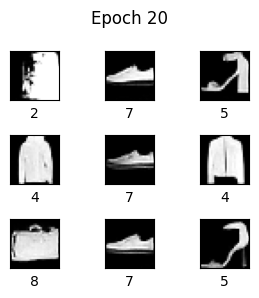

Epoch 20 | Loss: 0.023627382357602814


100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch 21 | Loss: 0.02366292037601982


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch 22 | Loss: 0.023463285790244016


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 23 | Loss: 0.023115097080418933


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 24 | Loss: 0.023169406814806497


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 25 | Loss: 0.022895368342317625


100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


Epoch 26 | Loss: 0.022634639009547385


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 27 | Loss: 0.02283133192857636


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 28 | Loss: 0.022837583309234077


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 29 | Loss: 0.022841814669099316


100%|██████████| 1000/1000 [00:19<00:00, 51.79it/s]


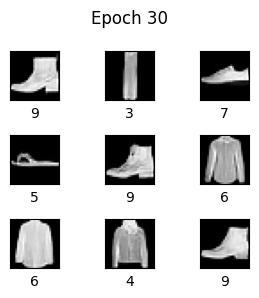

Epoch 30 | Loss: 0.022571745352434325


100%|██████████| 469/469 [00:55<00:00,  8.52it/s]


Epoch 31 | Loss: 0.022744616912578595


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 32 | Loss: 0.022410500681460666


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 33 | Loss: 0.022702388838727845


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 34 | Loss: 0.022668327679480318


100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Epoch 35 | Loss: 0.022117326639767395


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 36 | Loss: 0.022407230327346685


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 37 | Loss: 0.022272788357537692


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 38 | Loss: 0.022253374964284745


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch 39 | Loss: 0.022270075657140852


100%|██████████| 1000/1000 [00:19<00:00, 51.98it/s]


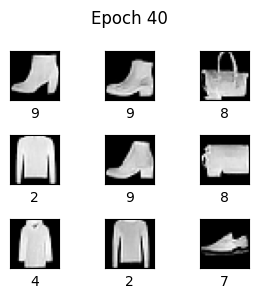

Epoch 40 | Loss: 0.02194738627544471


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


Epoch 41 | Loss: 0.02258829410666469


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 42 | Loss: 0.02223523884519204


100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Epoch 43 | Loss: 0.022168485690027412


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 44 | Loss: 0.021847258194852105


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 45 | Loss: 0.022059674309229036


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch 46 | Loss: 0.021732666491985575


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 47 | Loss: 0.021672650808289742


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


Epoch 48 | Loss: 0.021544820922953106


100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


Epoch 49 | Loss: 0.022318956464020684


100%|██████████| 1000/1000 [00:19<00:00, 52.40it/s]


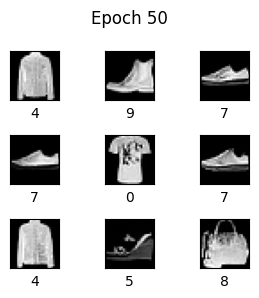

Epoch 50 | Loss: 0.02169324448312333


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 51 | Loss: 0.021851524990647714


100%|██████████| 469/469 [00:57<00:00,  8.23it/s]


Epoch 52 | Loss: 0.021497357606903703


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


Epoch 53 | Loss: 0.021747266025796755


100%|██████████| 469/469 [00:58<00:00,  8.00it/s]


Epoch 54 | Loss: 0.021802526171893072


100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


Epoch 55 | Loss: 0.02211113295742253


100%|██████████| 469/469 [00:59<00:00,  7.95it/s]


Epoch 56 | Loss: 0.021735619813172038


100%|██████████| 469/469 [00:58<00:00,  7.99it/s]


Epoch 57 | Loss: 0.02167500278104279


100%|██████████| 469/469 [00:57<00:00,  8.16it/s]


Epoch 58 | Loss: 0.02146915127751606


100%|██████████| 469/469 [00:56<00:00,  8.32it/s]


Epoch 59 | Loss: 0.02202177301907082


100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


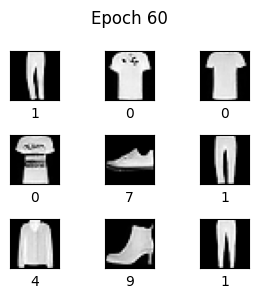

Epoch 60 | Loss: 0.021964871477502496


100%|██████████| 469/469 [00:55<00:00,  8.40it/s]


Epoch 61 | Loss: 0.021741216001448346


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Epoch 62 | Loss: 0.02173600565078162


100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 63 | Loss: 0.021657084936955208


100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 64 | Loss: 0.021585686618823614


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 65 | Loss: 0.02147833546444869


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


Epoch 66 | Loss: 0.021271279961394985


100%|██████████| 469/469 [00:57<00:00,  8.18it/s]


Epoch 67 | Loss: 0.021505015461381945


100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


Epoch 68 | Loss: 0.021176512196247003


100%|██████████| 469/469 [00:49<00:00,  9.46it/s]


Epoch 69 | Loss: 0.0217795309040751


100%|██████████| 1000/1000 [00:18<00:00, 53.59it/s]


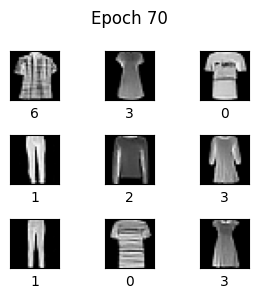

Epoch 70 | Loss: 0.021357246563394567


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Epoch 71 | Loss: 0.021415603887250046


100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Epoch 72 | Loss: 0.021266910652600245


100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Epoch 73 | Loss: 0.021518777180185068


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 74 | Loss: 0.021072530497445355


100%|██████████| 469/469 [00:59<00:00,  7.83it/s]


Epoch 75 | Loss: 0.021610608173490586


100%|██████████| 469/469 [01:01<00:00,  7.62it/s]


Epoch 76 | Loss: 0.021245703865676674


100%|██████████| 469/469 [01:01<00:00,  7.57it/s]


Epoch 77 | Loss: 0.021341731188012594


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 78 | Loss: 0.021302557977309615


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 79 | Loss: 0.021297729582086936


100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]


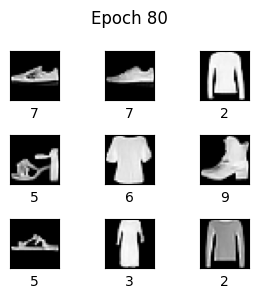

Epoch 80 | Loss: 0.02149073304787183


100%|██████████| 469/469 [01:01<00:00,  7.62it/s]


Epoch 81 | Loss: 0.021017682758459784


100%|██████████| 469/469 [00:55<00:00,  8.42it/s]


Epoch 82 | Loss: 0.02109253187892216


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 83 | Loss: 0.020970141493292377


100%|██████████| 469/469 [01:01<00:00,  7.60it/s]


Epoch 84 | Loss: 0.021797701289484113


100%|██████████| 469/469 [01:02<00:00,  7.56it/s]


Epoch 85 | Loss: 0.021404768155613686


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


Epoch 86 | Loss: 0.021038872066702543


100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Epoch 87 | Loss: 0.02103844826131551


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 88 | Loss: 0.021053434309881252


100%|██████████| 469/469 [01:01<00:00,  7.59it/s]


Epoch 89 | Loss: 0.021226700486690758


100%|██████████| 1000/1000 [00:19<00:00, 51.07it/s]


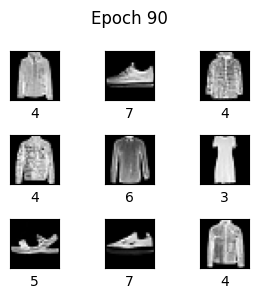

Epoch 90 | Loss: 0.020990166801220574


100%|██████████| 469/469 [00:59<00:00,  7.88it/s]


Epoch 91 | Loss: 0.020904055210763713


100%|██████████| 469/469 [00:58<00:00,  8.02it/s]


Epoch 92 | Loss: 0.02067981755881231


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]


Epoch 93 | Loss: 0.021200204724823233


100%|██████████| 469/469 [01:02<00:00,  7.53it/s]


Epoch 94 | Loss: 0.02068567436252004


100%|██████████| 469/469 [01:01<00:00,  7.57it/s]


Epoch 95 | Loss: 0.02121395320057678


100%|██████████| 469/469 [01:02<00:00,  7.54it/s]


Epoch 96 | Loss: 0.020564580437486997


100%|██████████| 469/469 [01:02<00:00,  7.50it/s]


Epoch 97 | Loss: 0.021175168865699884


100%|██████████| 469/469 [01:02<00:00,  7.52it/s]


Epoch 98 | Loss: 0.021188157177699018


100%|██████████| 469/469 [01:01<00:00,  7.58it/s]

Epoch 99 | Loss: 0.021206966780030777


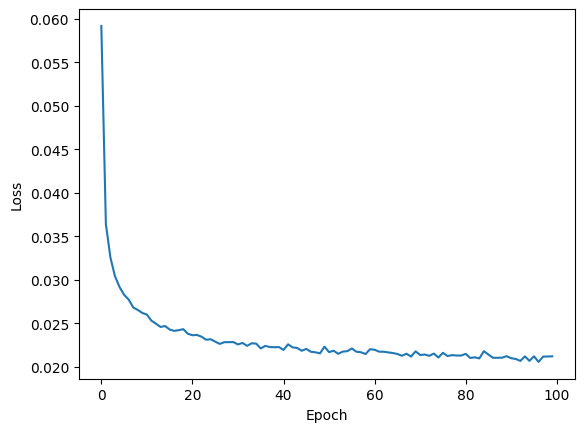

100%|██████████| 1000/1000 [00:19<00:00, 50.54it/s]


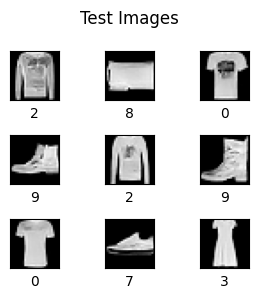

In [22]:
# step 5

img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

fashion_dataset = torchvision.datasets.FashionMNIST(root='./temp_data', download=True, transform=preprocess)
label_set = set()
img_lst = []
y_lst = []
for i, d in enumerate(fashion_dataset):
    label_set.add(d[1])
    if i < 9:
        img_lst.append(reverse_to_img(d[0]))
        y_lst.append(d[1])
show_images(img_lst, title_msg = "Ground Images", labels = y_lst)
print(f"Size of dataset: {len(label_set)}")
print(f"Label Set : {label_set}")

label_list = list(label_set)
num_labels = len(label_list)

fashion_diffuser = Diffuser(num_timesteps, device=device)
fashion_model = UNetCond(in_ch = 1, num_labels = num_labels)
fashion_model.to(device)

train(dataset = fashion_dataset, batch_size =  batch_size, label_list = label_list,
      diffuser = fashion_diffuser, num_timesteps =  num_timesteps,
      model = fashion_model, img_ch = 1, img_size =  img_size,
      device = device, epochs =  epochs, lr = lr)

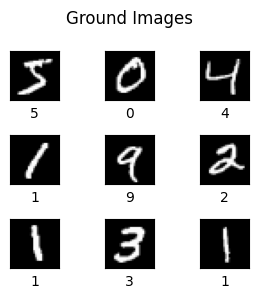

Size of dataset: 10
Label Set : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


100%|██████████| 1000/1000 [00:18<00:00, 53.14it/s]


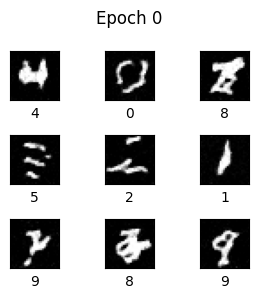

Epoch 0 | Loss: 0.0445730757953198


100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


Epoch 1 | Loss: 0.02524156366854207


100%|██████████| 469/469 [01:02<00:00,  7.47it/s]


Epoch 2 | Loss: 0.021558468722537763


100%|██████████| 469/469 [01:04<00:00,  7.31it/s]


Epoch 3 | Loss: 0.020812278603519332


100%|██████████| 469/469 [01:03<00:00,  7.36it/s]


Epoch 4 | Loss: 0.01909343952309094


100%|██████████| 469/469 [01:02<00:00,  7.48it/s]


Epoch 5 | Loss: 0.018792693753407072


100%|██████████| 469/469 [01:01<00:00,  7.65it/s]


Epoch 6 | Loss: 0.018191237584439548


100%|██████████| 469/469 [00:48<00:00,  9.73it/s]


Epoch 7 | Loss: 0.01763035039475033


100%|██████████| 469/469 [00:37<00:00, 12.45it/s]


Epoch 8 | Loss: 0.017340717491691807


100%|██████████| 469/469 [00:39<00:00, 11.84it/s]


Epoch 9 | Loss: 0.017260790171065944


100%|██████████| 1000/1000 [00:18<00:00, 55.03it/s]


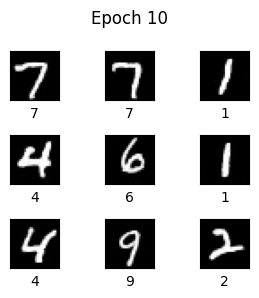

Epoch 10 | Loss: 0.016778067794880634


100%|██████████| 469/469 [00:37<00:00, 12.52it/s]


Epoch 11 | Loss: 0.01659157612660864


100%|██████████| 469/469 [00:37<00:00, 12.58it/s]


Epoch 12 | Loss: 0.016424163002401654


100%|██████████| 469/469 [00:37<00:00, 12.57it/s]


Epoch 13 | Loss: 0.01633155831038507


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 14 | Loss: 0.01617544401548247


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 15 | Loss: 0.015937250121427115


100%|██████████| 469/469 [00:37<00:00, 12.60it/s]


Epoch 16 | Loss: 0.015969538598506056


100%|██████████| 469/469 [00:37<00:00, 12.58it/s]


Epoch 17 | Loss: 0.015866722309910285


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 18 | Loss: 0.015757300704320482


100%|██████████| 469/469 [00:37<00:00, 12.47it/s]


Epoch 19 | Loss: 0.015551025012154569


100%|██████████| 1000/1000 [00:17<00:00, 58.70it/s]


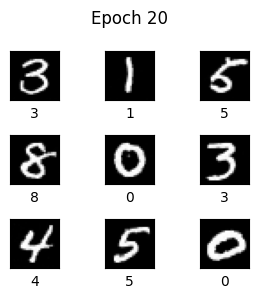

Epoch 20 | Loss: 0.015610728905335672


100%|██████████| 469/469 [00:48<00:00,  9.72it/s]


Epoch 21 | Loss: 0.015436879657050059


100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 22 | Loss: 0.015551590813454915


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 23 | Loss: 0.015433073109353402


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 24 | Loss: 0.015340003417308396


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 25 | Loss: 0.015158232724441013


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 26 | Loss: 0.015123868867484873


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 27 | Loss: 0.015100994030200342


100%|██████████| 469/469 [00:46<00:00, 10.18it/s]


Epoch 28 | Loss: 0.015002062071615191


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 29 | Loss: 0.014951016968374314


100%|██████████| 1000/1000 [00:17<00:00, 56.64it/s]


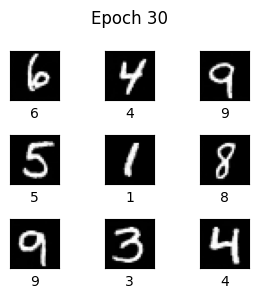

Epoch 30 | Loss: 0.014912264308393763


100%|██████████| 469/469 [00:37<00:00, 12.48it/s]


Epoch 31 | Loss: 0.014974448095157203


100%|██████████| 469/469 [00:37<00:00, 12.54it/s]


Epoch 32 | Loss: 0.0149405667010242


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 33 | Loss: 0.01461149547606516


100%|██████████| 469/469 [00:37<00:00, 12.62it/s]


Epoch 34 | Loss: 0.014760162296103262


100%|██████████| 469/469 [00:37<00:00, 12.56it/s]


Epoch 35 | Loss: 0.015034022659603467


100%|██████████| 469/469 [00:46<00:00, 10.17it/s]


Epoch 36 | Loss: 0.014771437387603687


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 37 | Loss: 0.014708525944016636


100%|██████████| 469/469 [00:47<00:00,  9.87it/s]


Epoch 38 | Loss: 0.014744117302990863


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 39 | Loss: 0.014601553661196726


100%|██████████| 1000/1000 [00:17<00:00, 56.73it/s]


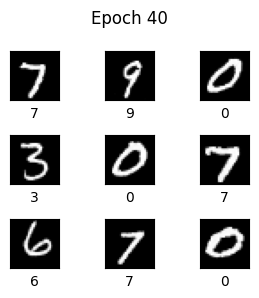

Epoch 40 | Loss: 0.014717247420504911


100%|██████████| 469/469 [00:48<00:00,  9.59it/s]


Epoch 41 | Loss: 0.01445972586054601


100%|██████████| 469/469 [00:47<00:00,  9.81it/s]


Epoch 42 | Loss: 0.01482807117492469


100%|██████████| 469/469 [00:47<00:00,  9.90it/s]


Epoch 43 | Loss: 0.014679302967814748


100%|██████████| 469/469 [00:47<00:00,  9.82it/s]


Epoch 44 | Loss: 0.01477401605003011


100%|██████████| 469/469 [00:47<00:00,  9.88it/s]


Epoch 45 | Loss: 0.01430481849416995


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch 46 | Loss: 0.014586288247630794


100%|██████████| 469/469 [00:37<00:00, 12.47it/s]


Epoch 47 | Loss: 0.014562656902380462


100%|██████████| 469/469 [00:37<00:00, 12.59it/s]


Epoch 48 | Loss: 0.014495714670861326


100%|██████████| 469/469 [00:37<00:00, 12.60it/s]


Epoch 49 | Loss: 0.014460092436260124


100%|██████████| 1000/1000 [00:17<00:00, 56.99it/s]


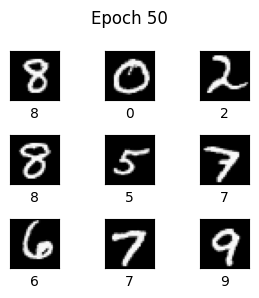

Epoch 50 | Loss: 0.01427362930736562


100%|██████████| 469/469 [00:49<00:00,  9.56it/s]


Epoch 51 | Loss: 0.014222926619067502


100%|██████████| 469/469 [00:46<00:00, 10.01it/s]


Epoch 52 | Loss: 0.014240018723568301


100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


Epoch 53 | Loss: 0.014220573631589855


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 54 | Loss: 0.014136458463124883


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 55 | Loss: 0.014169023826972507


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 56 | Loss: 0.014173059843417043


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 57 | Loss: 0.014448722447159447


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 58 | Loss: 0.014113596104371396


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 59 | Loss: 0.014204484652846988


100%|██████████| 1000/1000 [00:17<00:00, 56.70it/s]


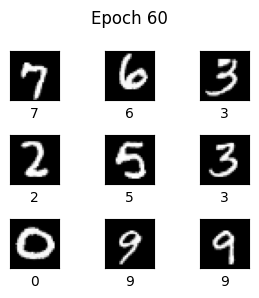

Epoch 60 | Loss: 0.014332424428290141


100%|██████████| 469/469 [00:48<00:00,  9.57it/s]


Epoch 61 | Loss: 0.014162365948833001


100%|██████████| 469/469 [00:47<00:00,  9.85it/s]


Epoch 62 | Loss: 0.014202575799006262


100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 63 | Loss: 0.014106162016524244


100%|██████████| 469/469 [00:47<00:00,  9.96it/s]


Epoch 64 | Loss: 0.014278932407037663


100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 65 | Loss: 0.013944919471309256


100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


Epoch 66 | Loss: 0.01424499508192036


100%|██████████| 469/469 [00:46<00:00, 10.13it/s]


Epoch 67 | Loss: 0.014126199422709977


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 68 | Loss: 0.014146485457272292


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


Epoch 69 | Loss: 0.013992118577697256


100%|██████████| 1000/1000 [00:17<00:00, 56.30it/s]


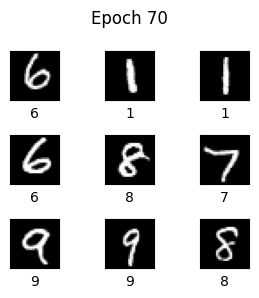

Epoch 70 | Loss: 0.014345024793800006


100%|██████████| 469/469 [00:48<00:00,  9.75it/s]


Epoch 71 | Loss: 0.013888301899724169


100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 72 | Loss: 0.0140712345594854


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 73 | Loss: 0.014137664146578388


100%|██████████| 469/469 [00:47<00:00,  9.92it/s]


Epoch 74 | Loss: 0.01406338548800076


100%|██████████| 469/469 [00:46<00:00, 10.04it/s]


Epoch 75 | Loss: 0.014059269286469738


100%|██████████| 469/469 [00:47<00:00,  9.88it/s]


Epoch 76 | Loss: 0.014019797712977507


100%|██████████| 469/469 [00:46<00:00,  9.98it/s]


Epoch 77 | Loss: 0.014187220563448823


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 78 | Loss: 0.014034570709093292


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 79 | Loss: 0.014153655914307785


100%|██████████| 1000/1000 [00:18<00:00, 55.07it/s]


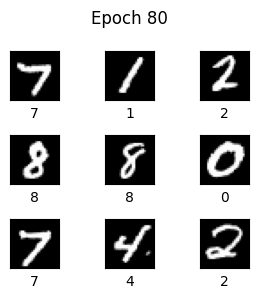

Epoch 80 | Loss: 0.014074994112128642


100%|██████████| 469/469 [00:37<00:00, 12.61it/s]


Epoch 81 | Loss: 0.013942537271280659


100%|██████████| 469/469 [00:37<00:00, 12.51it/s]


Epoch 82 | Loss: 0.014011384478446517


100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


Epoch 83 | Loss: 0.014021025899090746


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


Epoch 84 | Loss: 0.013923426049509283


100%|██████████| 469/469 [00:47<00:00,  9.98it/s]


Epoch 85 | Loss: 0.013940699259514239


100%|██████████| 469/469 [00:46<00:00, 10.11it/s]


Epoch 86 | Loss: 0.0138994944549954


100%|██████████| 469/469 [00:47<00:00,  9.79it/s]


Epoch 87 | Loss: 0.013989821307734449


100%|██████████| 469/469 [00:46<00:00, 10.07it/s]


Epoch 88 | Loss: 0.013952081155246382


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 89 | Loss: 0.013782550421938586


100%|██████████| 1000/1000 [00:17<00:00, 56.27it/s]


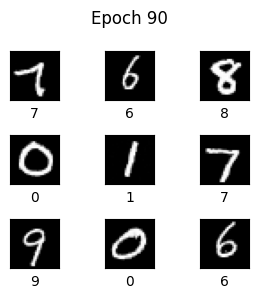

Epoch 90 | Loss: 0.013901212582313048


100%|██████████| 469/469 [00:48<00:00,  9.75it/s]


Epoch 91 | Loss: 0.014095083909677163


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


Epoch 92 | Loss: 0.01381570490788041


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


Epoch 93 | Loss: 0.01373353285957247


100%|██████████| 469/469 [00:47<00:00,  9.89it/s]


Epoch 94 | Loss: 0.013945762792836502


100%|██████████| 469/469 [00:47<00:00,  9.81it/s]


Epoch 95 | Loss: 0.013876748898787412


100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Epoch 96 | Loss: 0.013775327304469497


100%|██████████| 469/469 [00:47<00:00,  9.91it/s]


Epoch 97 | Loss: 0.014029265242392447


100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch 98 | Loss: 0.013694421598699682


100%|██████████| 469/469 [00:47<00:00,  9.98it/s]


Epoch 99 | Loss: 0.013835804810973882


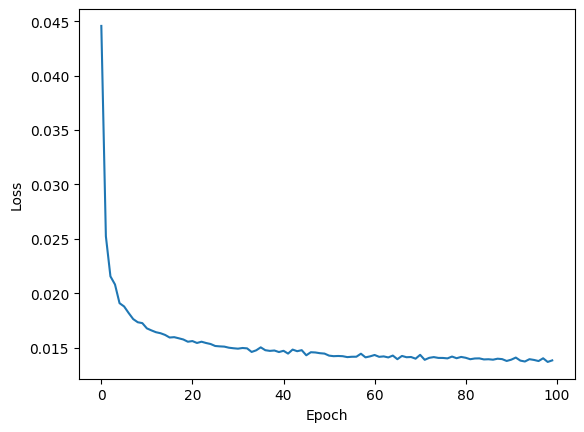

100%|██████████| 1000/1000 [00:17<00:00, 55.76it/s]


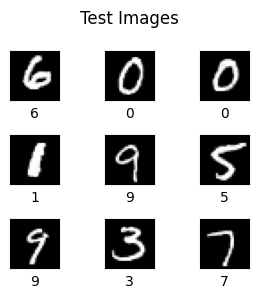

In [23]:
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 100
lr = 1e-3
# -----

preprocess = transforms.Compose([
    transforms.Resize(img_size),  # Resize the image
    transforms.CenterCrop(img_size), # Crop the center
    transforms.ToTensor() # Convert the image to a tensor
])

mnist_dataset = torchvision.datasets.MNIST(root='./temp_data', download=True, transform=preprocess)
label_set = set()
img_lst = []
y_lst = []
for i, d in enumerate(mnist_dataset):
    label_set.add(d[1])
    if i < 9:
        img_lst.append(reverse_to_img(d[0]))
        y_lst.append(d[1])
show_images(img_lst, title_msg = "Ground Images", labels = y_lst)
print(f"Size of dataset: {len(label_set)}")
print(f"Label Set : {label_set}")

label_list = list(label_set)
num_labels = len(label_list)

mnist_diffuser = Diffuser(num_timesteps, device=device)
mnist_model = UNetCond(in_ch = 1, num_labels = num_labels)
mnist_model.to(device)

train(dataset = mnist_dataset, batch_size =  batch_size, label_list = label_list,
      diffuser = mnist_diffuser, num_timesteps =  num_timesteps,
      model = mnist_model, img_ch = 1, img_size =  img_size,
      device = device, epochs =  epochs, lr = lr)